In [1]:
from pathlib import Path

# Check package versions
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion

# %matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
)
from gammapy.maps import Map, MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    create_crab_spectral_model,
)
from gammapy.visualization import plot_spectrum_datasets_off_regions

In [3]:
datastore = DataStore.from_dir("/raid/RAID1/VERITAS_Data/gammapy/LS5039/")

observations = datastore.get_observations()

In [4]:
target_position = SkyCoord(276.26  * u.deg, -13.97* u.deg, frame = "fk5")
on_region_radius = Angle("0.7 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

In [5]:
energy_axis = MapAxis.from_energy_bounds(
    0.5, 20, nbin=5, per_decade=True, unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    0.1, 100, nbin=20, per_decade=True, unit="TeV", name="energy_true"
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

In [6]:
geom_image = geom.to_wcs_geom()

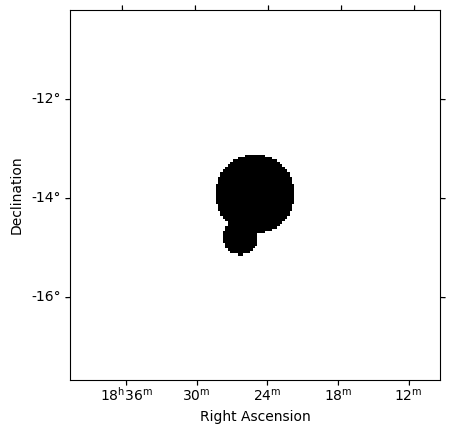

In [7]:
# get the geom that we use

# Make the exclusion mask
ls_position = SkyCoord.from_name("LS 5039")
region_ls = CircleSkyRegion(center=ls_position, radius=0.35 * u.deg)
regions = CircleSkyRegion(center=target_position, radius=0.8 * u.deg)
region_hess = CircleSkyRegion(center=SkyCoord(276.26  * u.deg, -13.97* u.deg, frame = "fk5"), radius=0.8 * u.deg)

all_ex = [regions, region_hess, region_ls]
# stars = []
# for star in srcs_tab:
#     pos = SkyCoord(star["RA"], star["DEC"], frame="fk5", unit=(u.hourangle, u.deg))
#     star = CircleSkyRegion(center=pos, radius=0.3 * u.deg)
#     stars.append(star)
#     all_ex.append(star)

# geom_image = geom.to_wcs_geom()
skydir = target_position.galactic
geom_image = WcsGeom.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)
exclusion_mask = ~geom_image.region_mask(all_ex)
exclusion_mask.sum_over_axes().plot()


source_only_mask = ~geom_image.region_mask([regions])
# exclusion_mask.write("exclusion_mask.fits", overwrite="True")

plt.show()

In [8]:
exclusion_mask

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat']
	shape : (150, 150)
	ndim  : 2
	unit  : 
	dtype : bool

In [9]:

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"],
    use_region_center=True
)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [10]:
obs_ids = observations.ids
print(observations[0])

Observation

	obs id            : 69054 
 	tstart            : 56451.43
	tstop             : 56451.45
	duration          : 2050.00 s
	pointing (icrs)   : 276.6 deg, -14.3 deg

	deadtime fraction : 9.2%



In [11]:
datasets = Datasets()

for obs_id, observation in zip(obs_ids, observations):
    print (obs_id)
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

print(datasets)

69054


ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '69054'.
ReflectedRegionsBackgroundMaker failed. Setting 69054 mask to False.


69123
69187
69188
69202


ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '69202'.
ReflectedRegionsBackgroundMaker failed. Setting 69202 mask to False.


69203
73193
73213


ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '73213'.
ReflectedRegionsBackgroundMaker failed. Setting 73213 mask to False.


73234
73300
73317
73335


ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '73335'.
ReflectedRegionsBackgroundMaker failed. Setting 73335 mask to False.


73356
73357
73390
73403


ReflectedRegionsBackgroundMaker failed. No OFF region found outside exclusion mask for dataset '73403'.
ReflectedRegionsBackgroundMaker failed. Setting 73403 mask to False.


73607
Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 69054
  Instrument : VERITAS
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 69123
  Instrument : VERITAS
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : 69187
  Instrument : VERITAS
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : 69188
  Instrument : VERITAS
  Models     : 

Dataset 4: 

  Type       : SpectrumDatasetOnOff
  Name       : 69202
  Instrument : VERITAS
  Models     : 

Dataset 5: 

  Type       : SpectrumDatasetOnOff
  Name       : 69203
  Instrument : VERITAS
  Models     : 

Dataset 6: 

  Type       : SpectrumDatasetOnOff
  Name       : 73193
  Instrument : VERITAS
  Models     : 

Dataset 7: 

  Type       : SpectrumDatasetOnOff
  Name       : 73213
  Instrument : VERITAS
  Models     : 

Dataset 8: 

  Type       : SpectrumDatasetOnOff
  Name       : 73234
  Instrument : VERITAS
  

AttributeError: 'NoneType' object has no attribute 'plot_region'

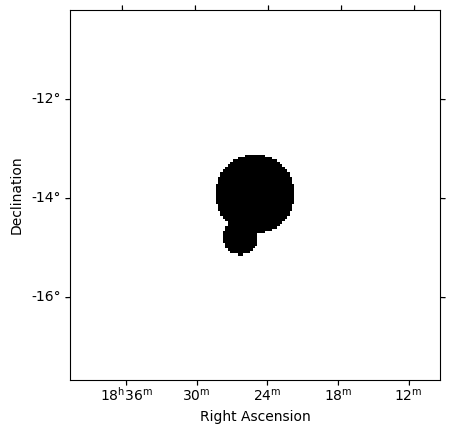

In [12]:
plt.figure()
ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)

In [13]:
info_table = datasets.info_table(cumulative=True)
print(
    f"Tobs={info_table['livetime'].to('h')[-1]:.1f} Excess={info_table['excess'].value[-1]:.1f} \
Significance={info_table['sqrt_ts'][-1]:.2f}"
)
display(info_table)

/home/obriens/mambaforge/envs/gammapy-tools/lib/python3.11/site-packages/gammapy/stats/counts_statistic.py:423: RuntimeWarning: invalid value encountered in scalar divide
  alpha = self.n_bkg.sum(axis=axis) / n_off
/home/obriens/mambaforge/envs/gammapy-tools/lib/python3.11/site-packages/gammapy/stats/counts_statistic.py:423: RuntimeWarning: invalid value encountered in scalar divide
  alpha = self.n_bkg.sum(axis=axis) / n_off


Tobs=4.3 h Excess=820.9 Significance=16.61


name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,0,nan,nan,nan,nan,0.0,nan,0.0,0.0,nan,2050.000000000001,nan,nan,nan,9,0,wstat,0.0,0,0.0,nan,nan
stacked,243,120.75,8.36402548769673,122.25,146.39999999999998,146.39999999999998,nan,2763.243896484375,295789504.0,1622.5074067808775,3853.0000000000045,0.1497681914944981,0.0753463432518617,0.07442184824263641,9,9,wstat,83.25766903013816,489,9.0,36.0,0.25
stacked,461,209.41668701171875,10.143750139517099,251.58331298828125,298.24360232753963,298.24360232753963,nan,179.85525512695312,650171264.0,3279.6771416590427,5656.000000000004,0.14056261640644316,0.07670978029898896,0.06385283610745421,9,9,wstat,115.7970879421176,877,9.0,31.37330436706543,0.2868680953979492
stacked,724,301.41668701171875,10.901023858697604,422.58331298828125,508.5342028841095,508.5342028841095,nan,187.59225463867188,1103780224.0,4946.56142182397,7459.000000000003,0.14636430001773554,0.08542971105622298,0.06093458896151256,9,9,wstat,137.03253414362,1048,9.0,22.319860458374023,0.4032283425331116
stacked,724,301.41668701171875,10.901023858697604,422.58331298828125,508.5342084708373,508.5342084708373,nan,187.59225463867188,1103780224.0,4946.56142182397,9262.000000000002,0.14636430001773554,0.08542971105622298,0.06093458896151256,9,9,wstat,137.03252777146548,1048,9.0,22.319860458374023,0.4032283425331116
stacked,948,398.6666259765625,12.88616209331863,549.3333740234375,652.0541320508104,652.0541320508104,nan,187.59225463867188,1397526272.0,6533.915511639763,11065.0,0.14508911208159903,0.0840741471243138,0.06101496495728522,9,9,wstat,186.65979104949,1555,9.0,25.476333618164062,0.3532690405845642
stacked,1136,437.6666259765625,12.444542311680511,698.3333740234375,824.8364937041324,824.8364937041324,nan,1076.45166015625,1637020160.0,7468.007101508368,12147.000000000004,0.15211554897565024,0.09351000401196592,0.05860554496368433,9,9,wstat,166.587557855176,1704,9.0,21.960857391357422,0.4098200500011444
stacked,1136,437.6666259765625,12.444542311680511,698.3333740234375,824.8364937041324,824.8364937041324,nan,1076.45166015625,1637020160.0,7468.007101508368,14248.000000000004,0.15211554897565024,0.09351000401196592,0.05860554496368433,9,9,wstat,166.587557855176,1704,9.0,21.960857391357422,0.4098200500011444


Text(0, 0.5, 'Sqrt(TS)')

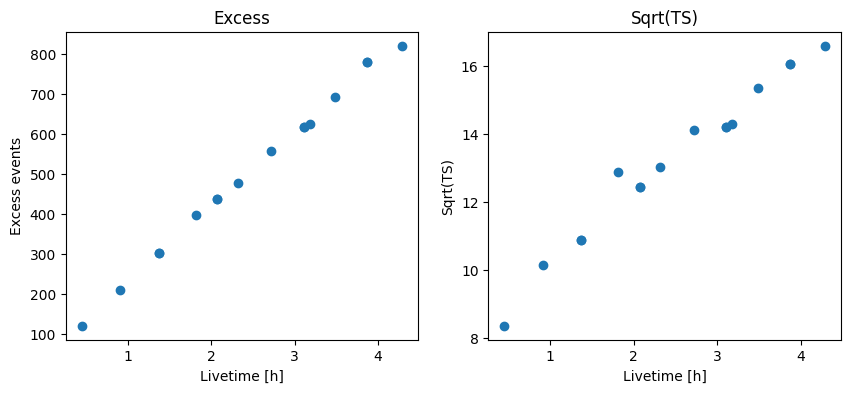

In [14]:
fig, (ax_excess, ax_sqrt_ts) = plt.subplots(figsize=(10, 4), ncols=2, nrows=1)
ax_excess.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    ls="none",
)

ax_excess.set_title("Excess")
ax_excess.set_xlabel("Livetime [h]")
ax_excess.set_ylabel("Excess events")

ax_sqrt_ts.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)

ax_sqrt_ts.set_title("Sqrt(TS)")
ax_sqrt_ts.set_xlabel("Livetime [h]")
ax_sqrt_ts.set_ylabel("Sqrt(TS)")

In [15]:
path = Path("spectrum_analysis_HESS")
path.mkdir(exist_ok=True)

for dataset in datasets:
    dataset.write(filename=path / f"obs_{dataset.name}.fits.gz", overwrite=True)

In [16]:
spectral_model = PowerLawSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    index=2,
    reference=1 * u.TeV,
)
model = SkyModel(spectral_model=spectral_model, name="HESS J1825-137")

datasets.models = [model]

fit_joint = Fit()
result_joint = fit_joint.run(datasets=datasets)

# we make a copy here to compare it later
model_best_joint = model.copy()

In [17]:
print(result_joint)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 103
	total stat : 152.31

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [18]:
display(result_joint.models.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str14,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
HESS J1825-137,spectral,index,2.4850e+00,,7.659e-02,nan,nan,False,False,
HESS J1825-137,spectral,amplitude,2.3942e-11,TeV-1 s-1 cm-2,1.616e-12,nan,nan,False,True,
HESS J1825-137,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='$\\mathrm{}$'>

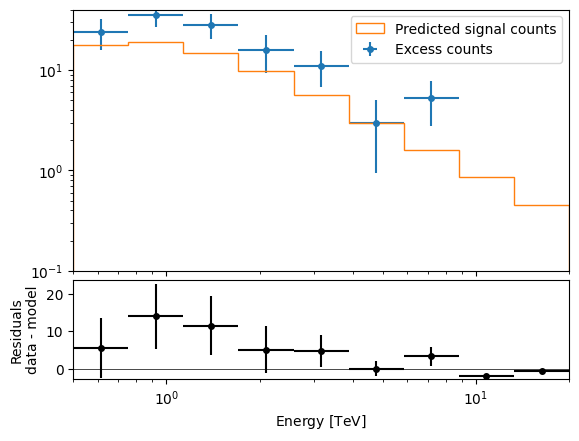

In [19]:
plt.figure()
ax_spectrum, ax_residuals = datasets[1].plot_fit()
ax_spectrum.set_ylim(0.1, 40)
datasets[0].plot_masks(ax=ax_spectrum)

In [20]:
e_min, e_max = 0.5, 20
energy_edges = np.geomspace(e_min, e_max, 10) * u.TeV

In [21]:
fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source="HESS J1825-137", selection_optional="all"
)
flux_points = fpe.run(datasets=datasets)

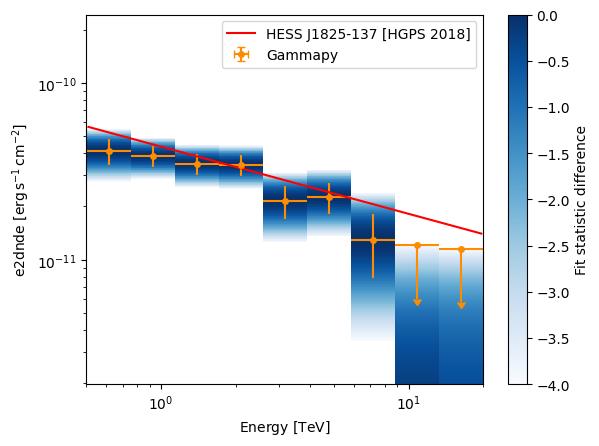

In [22]:
fig, ax = plt.subplots()

erange = (0.5, 20) * u.TeV

flux_points.plot(ax=ax, sed_type="e2dnde", color="darkorange", label = "Gammapy")
flux_points.plot_ts_profiles(ax=ax, sed_type="e2dnde")


model_HESS_tevcat = PowerLawSpectralModel(
    amplitude = 1.91e-11 / u.TeV / u.cm / u.cm /u.s,
    index = 2.38,
    reference = 1.16 * u.TeV
)

model_HESS_tevcat.plot(
    energy_bounds = erange,
    label = "HESS J1825-137 [HGPS 2018]", sed_type = "e2dnde",
    color = "r"
)

plt.legend()